In [1]:
# ==============================================================
# 1) IMPORTS
# ==============================================================
%pip install mlflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import mlflow
import os
import sqlalchemy
import shutil
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports carregados com sucesso!")

Note: you may need to restart the kernel to use updated packages.
✅ Imports carregados com sucesso!


In [2]:
# ==============================================================
# 2) CARREGANDO DADOS DA PIPELINE (POSTGRESQL)
# ==============================================================
DB_URL = "postgresql://admin:secret@db:5432/weather_db" 
TABLE_NAME = "weather_measurements"

try:
    engine = sqlalchemy.create_engine(DB_URL)
    df_raw = pd.read_sql(f"SELECT * FROM {TABLE_NAME} ORDER BY timestamp", engine)
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
    df_raw = df_raw.set_index('timestamp')
    
    df_raw.rename(columns={
        'temperature': 'Temp', 
        'humidity': 'Umi', 
        'wind_speed': 'Vento', 
        'radiation': 'Rad', 
        'precipitation': 'Chuva'
    }, inplace=True)
    
    df_raw = df_raw.loc[~df_raw.index.duplicated(keep='last')]
    print(f"✔️ Dados lidos do PostgreSQL. Total de registros: {len(df_raw)}")

except Exception as e:
    print(f"❌ ERRO ao conectar ou ler do PostgreSQL: {e}")
    if os.path.exists("data/dados_tratados.csv"):
        print("Usando fallback CSV...")
        df_raw = pd.read_csv("data/dados_tratados.csv", index_col=0, parse_dates=True)
        df_raw.columns = ['Temp', 'Umi', 'Vento', 'Rad', 'Chuva']
    else:
        raise ConnectionError("Falha crítica: Não foi possível conectar ao DB e o CSV de fallback não existe.")

✔️ Dados lidos do PostgreSQL. Total de registros: 759


In [3]:
# ==============================================================
# 3) PREPROCESSAMENTO E FEATURE ENGINEERING
# ==============================================================
df = df_raw[['Temp', 'Umi', 'Vento', 'Rad', 'Chuva']].copy()

# Interpolação e preenchimento de NaNs
df = df.interpolate(method="time")
df["Rad"] = df["Rad"].fillna(0)
df = df.ffill().bfill()

if df.isnull().values.any():
    df = df.fillna(0)
    print("✅ NaNs restantes preenchidos com 0.")

print(f"Tamanho do DF após limpeza: {len(df)} linhas.")

# Feature Engineering
df_model = df.copy()

lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    df_model[f"Temp_lag_{lag}"] = df_model["Temp"].shift(lag)
    df_model[f"Umi_lag_{lag}"] = df_model["Umi"].shift(lag)
    df_model[f"Vento_lag_{lag}"] = df_model["Vento"].shift(lag)
    df_model[f"Rad_lag_{lag}"] = df_model["Rad"].shift(lag)

df_model["hour"] = df_model.index.hour
df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)

# Target → previsão para 1 hora à frente
df_model["Temp_future_1h"] = df_model["Temp"].shift(-1)

# Remover colunas originais e manter apenas features de lag
df_model.drop(columns=['Temp', 'Umi', 'Vento', 'Rad', 'Chuva', 'hour'], inplace=True)
df_model = df_model.dropna()

print(f"\nShape final do dataset de modelagem: {df_model.shape}")
print(f"Features: {list(df_model.columns[:-1])}")

Tamanho do DF após limpeza: 759 linhas.

Shape final do dataset de modelagem: (734, 27)
Features: ['Temp_lag_1', 'Umi_lag_1', 'Vento_lag_1', 'Rad_lag_1', 'Temp_lag_2', 'Umi_lag_2', 'Vento_lag_2', 'Rad_lag_2', 'Temp_lag_3', 'Umi_lag_3', 'Vento_lag_3', 'Rad_lag_3', 'Temp_lag_6', 'Umi_lag_6', 'Vento_lag_6', 'Rad_lag_6', 'Temp_lag_12', 'Umi_lag_12', 'Vento_lag_12', 'Rad_lag_12', 'Temp_lag_24', 'Umi_lag_24', 'Vento_lag_24', 'Rad_lag_24', 'hour_sin', 'hour_cos']


In [4]:
# ==============================================================
# 4) SEPARAÇÃO TREINO / TESTE
# ==============================================================
X = df_model.drop(columns=["Temp_future_1h"])
y = df_model["Temp_future_1h"]

# Guardar as features para uso posterior na API
FEATURE_COLUMNS = list(X.columns)
print(f"\n📊 Features do modelo ({len(FEATURE_COLUMNS)} total):")
print(FEATURE_COLUMNS)

TEST_SIZE_PERCENTAGE = 0.2
MIN_TEST_ROWS = 5

if len(X) <= (lags[-1] + MIN_TEST_ROWS):
    raise ValueError(f"Dataset muito pequeno ({len(X)} linhas).")

test_size_val = TEST_SIZE_PERCENTAGE if len(X) >= 50 else MIN_TEST_ROWS

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size_val, shuffle=False
)

print(f"\nTamanhos:")
print(f"  Treino: {X_train.shape}")
print(f"  Teste: {X_test.shape}")


📊 Features do modelo (26 total):
['Temp_lag_1', 'Umi_lag_1', 'Vento_lag_1', 'Rad_lag_1', 'Temp_lag_2', 'Umi_lag_2', 'Vento_lag_2', 'Rad_lag_2', 'Temp_lag_3', 'Umi_lag_3', 'Vento_lag_3', 'Rad_lag_3', 'Temp_lag_6', 'Umi_lag_6', 'Vento_lag_6', 'Rad_lag_6', 'Temp_lag_12', 'Umi_lag_12', 'Vento_lag_12', 'Rad_lag_12', 'Temp_lag_24', 'Umi_lag_24', 'Vento_lag_24', 'Rad_lag_24', 'hour_sin', 'hour_cos']

Tamanhos:
  Treino: (587, 26)
  Teste: (147, 26)


In [5]:
# ==============================================================
# 5) DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS
# ==============================================================

# Espaço de busca para RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],           # Número de árvores
    'max_depth': [5, 10, 15, 20, 30, None],             # Profundidade máxima
    'min_samples_split': [2, 5, 10, 15],               # Mínimo de amostras para split
    'min_samples_leaf': [1, 2, 4, 6],                  # Mínimo de amostras por folha
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],   # Features por split
    'bootstrap': [True, False]                          # Usar bootstrap
}

print("🔧 Espaço de Hiperparâmetros definido:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

🔧 Espaço de Hiperparâmetros definido:
  n_estimators: [50, 100, 200, 300, 500]
  max_depth: [5, 10, 15, 20, 30, None]
  min_samples_split: [2, 5, 10, 15]
  min_samples_leaf: [1, 2, 4, 6]
  max_features: ['sqrt', 'log2', 0.3, 0.5, 0.7]
  bootstrap: [True, False]


In [6]:
# ==============================================================
# 6) RANDOMIZED SEARCH COM TIME SERIES SPLIT
# ==============================================================

# TimeSeriesSplit é adequado para séries temporais (não mistura dados futuros no treino)
n_splits = min(5, len(X_train) // 10)  # Ajustar splits baseado no tamanho
n_splits = max(2, n_splits)  # Mínimo de 2 splits

tscv = TimeSeriesSplit(n_splits=n_splits)

# Modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# RandomizedSearchCV
n_iter = min(50, len(X_train) // 5)  # Número de iterações baseado no tamanho
n_iter = max(10, n_iter)  # Mínimo de 10 iterações

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # Otimizar para RMSE
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print(f"\n🚀 Iniciando RandomizedSearchCV...")
print(f"   - Iterações: {n_iter}")
print(f"   - TimeSeriesSplit folds: {n_splits}")
print(f"   - Métrica: RMSE (neg_root_mean_squared_error)")
print(f"\n⏳ Isso pode levar alguns minutos...")


🚀 Iniciando RandomizedSearchCV...
   - Iterações: 50
   - TimeSeriesSplit folds: 5
   - Métrica: RMSE (neg_root_mean_squared_error)

⏳ Isso pode levar alguns minutos...


In [7]:
# ==============================================================
# 7) EXECUTAR A BUSCA DE HIPERPARÂMETROS
# ==============================================================

random_search.fit(X_train, y_train)

print("\n" + "="*60)
print("✅ BUSCA FINALIZADA!")
print("="*60)
print(f"\n🏆 Melhores Hiperparâmetros:")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n📈 Melhor Score CV (RMSE): {-random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ BUSCA FINALIZADA!

🏆 Melhores Hiperparâmetros:
   n_estimators: 500
   min_samples_split: 5
   min_samples_leaf: 1
   max_features: sqrt
   max_depth: 10
   bootstrap: False

📈 Melhor Score CV (RMSE): 0.5710


In [8]:
# ==============================================================
# 8) AVALIAR O MODELO OTIMIZADO NO CONJUNTO DE TESTE
# ==============================================================

# Melhor modelo encontrado
best_rf = random_search.best_estimator_

# Predições no teste
y_pred = best_rf.predict(X_test)

# Métricas finais
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("📊 MÉTRICAS NO CONJUNTO DE TESTE")
print("="*60)
print(f"   RMSE: {rmse:.4f} °C")
print(f"   MAE:  {mae:.4f} °C")
print(f"   R²:   {r2:.4f}")


📊 MÉTRICAS NO CONJUNTO DE TESTE
   RMSE: 0.1118 °C
   MAE:  0.0765 °C
   R²:   0.9962


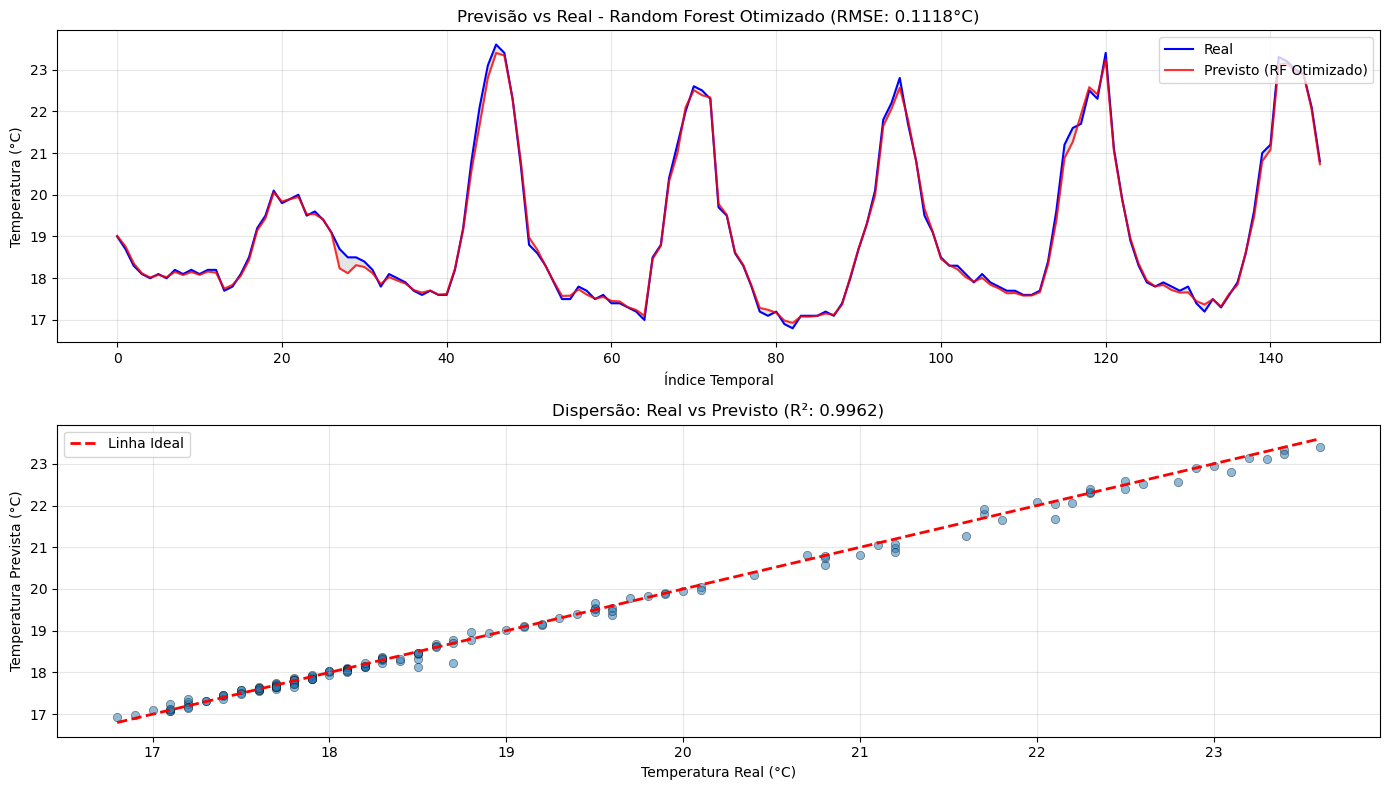


📁 Gráfico salvo em: data/previsao_vs_real_otimizado.png


In [9]:
# ==============================================================
# 9) VISUALIZAÇÃO: PREVISÃO VS REAL
# ==============================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Série temporal
ax1 = axes[0]
ax1.plot(y_test.values, label="Real", color='blue', linewidth=1.5)
ax1.plot(y_pred, label="Previsto (RF Otimizado)", color='red', linewidth=1.5, alpha=0.8)
ax1.fill_between(range(len(y_test)), y_test.values, y_pred, alpha=0.2, color='gray')
ax1.set_xlabel("Índice Temporal")
ax1.set_ylabel("Temperatura (°C)")
ax1.set_title(f"Previsão vs Real - Random Forest Otimizado (RMSE: {rmse:.4f}°C)")
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter plot
ax2 = axes[1]
ax2.scatter(y_test, y_pred, alpha=0.5, edgecolors='black', linewidth=0.5)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal')
ax2.set_xlabel("Temperatura Real (°C)")
ax2.set_ylabel("Temperatura Prevista (°C)")
ax2.set_title(f"Dispersão: Real vs Previsto (R²: {r2:.4f})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/previsao_vs_real_otimizado.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📁 Gráfico salvo em: data/previsao_vs_real_otimizado.png")


🔍 Top 10 Features Mais Importantes:
   feature  importance
 Rad_lag_1    0.192831
Temp_lag_1    0.149556
 Rad_lag_2    0.103715
 Umi_lag_1    0.096110
Rad_lag_12    0.070621
 Rad_lag_6    0.050838
Temp_lag_6    0.041967
 Rad_lag_3    0.041712
Temp_lag_2    0.036098
Rad_lag_24    0.033667


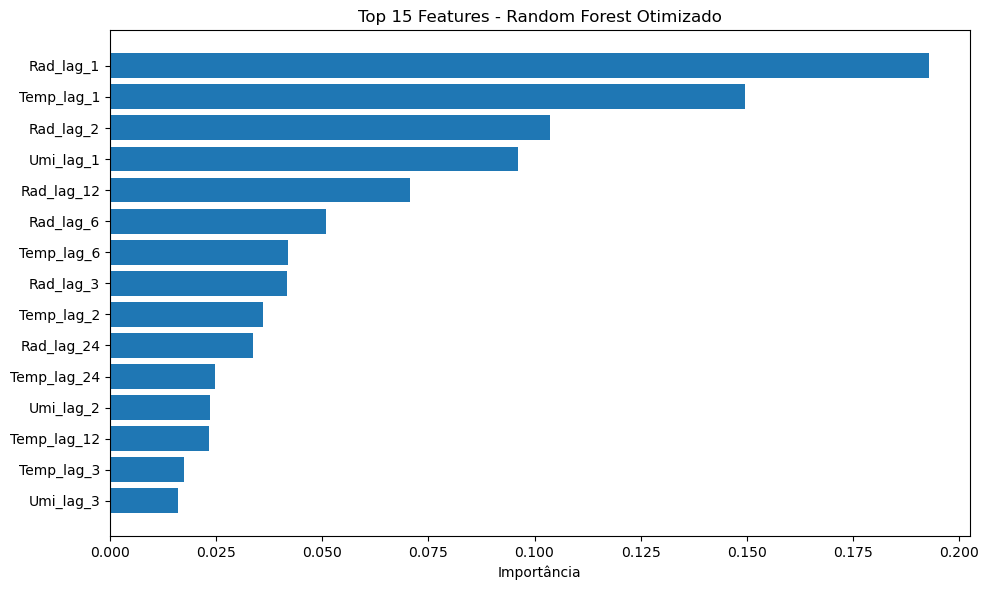

In [10]:
# ==============================================================
# 10) FEATURE IMPORTANCE
# ==============================================================

feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Features Mais Importantes:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Importância')
plt.title('Top 15 Features - Random Forest Otimizado')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('data/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ==============================================================
# 11) LOGAR MODELO OTIMIZADO NO MLFLOW
# ==============================================================

# Configurar MLflow (URI do servidor)
mlflow.set_tracking_uri("http://mlflow:5000")
mlflow.set_experiment("Weather_Temperature_Prediction")

with mlflow.start_run(run_name="RandomForest_Optimized"):
    
    # Log dos hiperparâmetros otimizados
    for param, value in random_search.best_params_.items():
        mlflow.log_param(param, value)
    
    # Log das métricas
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("cv_rmse", -random_search.best_score_)
    
    # Log dos artefatos (gráficos)
    if os.path.exists('data/previsao_vs_real_otimizado.png'):
        mlflow.log_artifact('data/previsao_vs_real_otimizado.png')
    if os.path.exists('data/feature_importance.png'):
        mlflow.log_artifact('data/feature_importance.png')
    
    # Salvar modelo localmente e logar artefatos
    model_path = "RandomForest_Optimized_model"
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
        print(f"⚠️ Limpando pasta local: {model_path}")
    
    # Salvar modelo com assinatura para facilitar deploy
    from mlflow.models.signature import infer_signature
    signature = infer_signature(X_train, best_rf.predict(X_train))
    
    mlflow.sklearn.save_model(
        best_rf, 
        model_path,
        signature=signature
    )
    mlflow.log_artifacts(model_path, artifact_path="model")
    
    # Também logar as features utilizadas
    import json
    with open('model_features.json', 'w') as f:
        json.dump({
            'features': FEATURE_COLUMNS,
            'lags': lags,
            'best_params': random_search.best_params_
        }, f, indent=2)
    mlflow.log_artifact('model_features.json')
    
    run_id = mlflow.active_run().info.run_id
    
print("\n" + "="*60)
print("✅ MODELO OTIMIZADO LOGADO NO MLFLOW!")
print("="*60)
print(f"   Run ID: {run_id}")
print(f"   Experiment: Weather_Temperature_Prediction")

In [ ]:
# ==============================================================
# 12) SALVAR MODELO LOCAL PARA FASTAPI
# ==============================================================

# Salvar uma cópia do modelo para ser usada pela FastAPI
import pickle

model_data = {
    'model': best_rf,
    'features': FEATURE_COLUMNS,
    'lags': lags,
    'best_params': random_search.best_params_,
    'metrics': {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
}

# Salvar na pasta data (compartilhada com FastAPI via volume)
with open('data/rf_optimized_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\n✅ Modelo salvo em: data/rf_optimized_model.pkl")
print(f"   Tamanho: {os.path.getsize('data/rf_optimized_model.pkl') / 1024:.2f} KB")

In [ ]:
# ==============================================================
# 13) COMPARAÇÃO: MODELO BASE VS OTIMIZADO
# ==============================================================

# Treinar modelo base (sem otimização) para comparação
rf_base_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_base_model.fit(X_train, y_train)
y_pred_base = rf_base_model.predict(X_test)

rmse_base = mean_squared_error(y_test, y_pred_base, squared=False)
mae_base = mean_absolute_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

print("\n" + "="*60)
print("📊 COMPARAÇÃO: MODELO BASE vs OTIMIZADO")
print("="*60)
print(f"\n{'Métrica':<10} {'Base':<15} {'Otimizado':<15} {'Melhoria':<15}")
print("-"*55)
print(f"{'RMSE':<10} {rmse_base:<15.4f} {rmse:<15.4f} {((rmse_base-rmse)/rmse_base)*100:>+.2f}%")
print(f"{'MAE':<10} {mae_base:<15.4f} {mae:<15.4f} {((mae_base-mae)/mae_base)*100:>+.2f}%")
print(f"{'R²':<10} {r2_base:<15.4f} {r2:<15.4f} {((r2-r2_base)/r2_base)*100:>+.2f}%")

In [ ]:
# ==============================================================
# 14) RESUMO FINAL
# ==============================================================

print("\n" + "="*70)
print("                    🎯 RESUMO DA OTIMIZAÇÃO")
print("="*70)
print(f"\n📊 Dataset:")
print(f"   - Total de registros: {len(df_model)}")
print(f"   - Features: {len(FEATURE_COLUMNS)}")
print(f"   - Treino: {len(X_train)} | Teste: {len(X_test)}")

print(f"\n🔧 Otimização:")
print(f"   - Método: RandomizedSearchCV")
print(f"   - Validação: TimeSeriesSplit ({n_splits} folds)")
print(f"   - Iterações: {n_iter}")

print(f"\n🏆 Melhores Hiperparâmetros:")
for param, value in random_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📈 Métricas Finais (Teste):")
print(f"   - RMSE: {rmse:.4f}°C")
print(f"   - MAE:  {mae:.4f}°C")
print(f"   - R²:   {r2:.4f}")

print(f"\n💾 Artefatos:")
print(f"   - MLflow Run ID: {run_id}")
print(f"   - Modelo local: data/rf_optimized_model.pkl")
print(f"   - Gráficos: data/previsao_vs_real_otimizado.png")
print(f"              data/feature_importance.png")

print("\n" + "="*70)
print("✅ OTIMIZAÇÃO CONCLUÍDA COM SUCESSO!")
print("   Próximo passo: Integrar modelo na FastAPI (/predict)")
print("="*70)